In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using AtomsBuilder
using ComponentArrays
using DFTK
using ForwardDiff
using LinearAlgebra
using Plots
using PseudoPotentialData
using Random
using Unitful
using UnitfulAtomic

  Activating project at `~/git/tutorial-cecam-workshop-dftk-2025`


# Defining a custom XC functional in DftFunctionals.jl

It is easy to define a new exchange-correlation functional and use it with DFTK.
Defining an energy expression is sufficient: We will use ForwardDiff
to automatically compute exchange-correlation energy derivatives of 
- first-order (for SCF): the XC potential $V_\text{xc} = \frac{\partial E_\text{xc}}{\partial \rho}$, and
- second-order (for DFPT): the XC kernel $\frac{\partial V_\text{xc}}{\partial \rho}$, and the potential-parameter-derivative $\frac{\partial V_\text{xc}}{\partial \theta}$

(*Technical remark: Currently this functionality is limited to GGA-type functionals.*)

In [2]:
include("beef.jl")  # see this file for the BEEF functional implementation in few lines

Main.Beef

Let's visualize the exchange-enhancement factor ensemble (as Fig 1. in https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.95.216401)

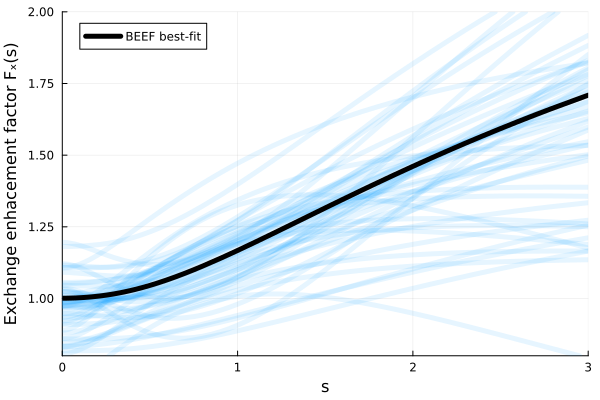

In [3]:
let 
    params = Beef.params_beef_2005()
    rng = MersenneTwister(1234)
    n_samples = 50
    α = randn(rng, 3, n_samples)
    δθ_ensemble = params.L * α
    fig_fx_ensemble = plot(xlim=(0,3), ylim=(0.8, 2.0), xlabel="s", ylabel="Exchange enhacement factor Fₓ(s)")
    for δθ in eachcol(δθ_ensemble)
        plot!(fig_fx_ensemble, s -> Beef.f_x_beef(s, params.θ_bf + δθ), label=nothing,
        color=1, linealpha=0.1, lw=5)
    end
    plot!(fig_fx_ensemble, s -> Beef.f_x_beef(s, params.θ_bf), label="BEEF best-fit",
    linewidth=5, color=:black)
    fig_fx_ensemble
end

## Using the custom XC functional in DFTK

In [4]:
params = Beef.params_beef_2005()
make_functionals(θ) = Beef.make_beef(θ)
functionals = make_functionals(params.θ_bf)

2-element Vector{DftFunctionals.Functional{:gga}}:
 gga_c_pbe
 gga_x_beef_custom

In [5]:
a0_beef = 10.328164895118894  # From a prior geometry relaxation
a0 = a0_beef
system = bulk(:Si; a=a0_beef * u"bohr")

# Set up DFT model
pseudopotentials = PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
(; lattice, atoms, positions) = DFTK.parse_system(system, pseudopotentials)
model = model_DFT(lattice, atoms, positions; functionals, temperature=1e-3)
symmetries = model.symmetries

# Discretization
Ecut = recommended_cutoff(model).Ecut
kgrid = (8, 8, 8)
basis = PlaneWaveBasis(model; Ecut, kgrid)

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. DFTK  threads   : 1
    num. blas  threads   : 6
    num. fft   threads   : 1

    Ecut                 : 18.0 Ha
    fft_size             : (32, 32, 32), 32768 total points
    kgrid                : MonkhorstPack([8, 8, 8])
    num.   red. kpoints  : 512
    num. irred. kpoints  : 29

    Discretized Model(gga_c_pbe+gga_x_beef_custom, 3D):
        lattice (in Bohr)    : [0         , 5.16408   , 5.16408   ]
                               [5.16408   , 0         , 5.16408   ]
                               [5.16408   , 5.16408   , 0         ]
        unit cell volume     : 275.43 Bohr³
    
        atoms                : Si₂
        pseudopot. family    : PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
    
        num. electrons       : 8
        spin polarization    : none
        temperature          : 0.001 Ha
        smearing             : DFTK.

In [6]:
scfres = self_consistent_field(basis; tol=1e-8)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450557830002                   -0.96    4.3    5.85s
  2   -8.452301256263       -2.76       -1.48    1.0    3.05s
  3   -8.452534172739       -3.63       -2.84    1.6    567ms
  4   -8.452557921884       -4.62       -3.33    3.4    624ms
  5   -8.452557978618       -7.25       -3.74    1.4    839ms
  6   -8.452557994147       -7.81       -4.49    2.1    658ms
  7   -8.452557995411       -8.90       -5.06    2.6    482ms
  8   -8.452557995474      -10.20       -5.44    2.2    455ms
  9   -8.452557995484      -10.96       -7.11    2.4    461ms
 10   -8.452557995485      -12.26       -6.84    4.4    1.16s
 11   -8.452557995485      -13.08       -7.65    1.0    380ms
 12   -8.452557995485      -14.75       -7.98    1.5    469ms
 13   -8.452557995485   +    -Inf       -8.62    1.4    405ms


(ham = Hamiltonian(PlaneWaveBasis(model = Model(gga_c_pbe+gga_x_beef_custom, spin_polarization = :none), Ecut = 18.0 Ha, kgrid = MonkhorstPack([8, 8, 8])), HamiltonianBlock[DFTK.DftHamiltonianBlock(PlaneWaveBasis(model = Model(gga_c_pbe+gga_x_beef_custom, spin_polarization = :none), Ecut = 18.0 Ha, kgrid = MonkhorstPack([8, 8, 8])), KPoint([     0,      0,      0], spin = 1, num. G vectors =   965), Any[DFTK.FourierMultiplication{Float64, Vector{Float64}}(PlaneWaveBasis(model = Model(gga_c_pbe+gga_x_beef_custom, spin_polarization = :none), Ecut = 18.0 Ha, kgrid = MonkhorstPack([8, 8, 8])), KPoint([     0,      0,      0], spin = 1, num. G vectors =   965), [0.0, 0.5551427464074018, 2.220570985629607, 4.996284717666616, 8.882283942518429, 13.878568660185042, 13.878568660185042, 8.882283942518429, 4.996284717666616, 2.220570985629607  …  2.0355234034938063, 4.4411419712592135, 7.957046031839424, 12.583235585234439, 16.284187227950454, 10.917807346012234, 6.661712956888822, 3.515904060580

In [7]:
compute_stresses_cart(scfres)

3×3 StaticArraysCore.SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
 9.76193e-7   0.0          0.0
 5.64689e-22  9.76193e-7   0.0
 0.0          5.64689e-22  9.76193e-7

## Computing XC parameter sensitivities by AD-DFPT

In [8]:
function setup_basis(a, θ; Ecut, kgrid)
    T = promote_type(eltype(a), eltype(θ))
    lattice_new = (a / a0) * lattice
    model_new = model_DFT(T.(lattice_new), atoms, positions;
                          functionals=make_functionals(θ), symmetries)
    basis_new = PlaneWaveBasis(model_new; Ecut, kgrid)
end

setup_basis (generic function with 1 method)

In [9]:
function hellmann_feynman_observables(a, θ; Ecut, kgrid, tol)
    # 1. Setup
    basis = setup_basis(a, θ; Ecut, kgrid)

    # 2. Solve
    scfres = self_consistent_field(basis; tol)

    # 3. Postprocess
    grads = ForwardDiff.gradient(ComponentVector(; a, θ)) do x
        basis_new = setup_basis(x.a, x.θ; Ecut, kgrid)
        ρ = compute_density(basis_new, scfres.ψ, scfres.occupation)
        (; energies) = DFTK.energy(basis_new, scfres.ψ, scfres.occupation;
                                   ρ, scfres.eigenvalues, scfres.εF)
        energies.total
    end

    grads
end

hellmann_feynman_observables (generic function with 1 method)

In [10]:
hellmann_feynman_observables(a0, params.θ_bf; Ecut, kgrid, tol=1e-6)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450489759409                   -0.96    4.3    2.85s
  2   -8.452394294291       -2.72       -1.81    1.0    1.04s
  3   -8.452548808192       -3.81       -2.91    2.0    403ms
  4   -8.452557901952       -5.04       -3.40    3.0    931ms
  5   -8.452558004349       -6.99       -3.99    1.5    356ms
  6   -8.452558011021       -8.18       -5.19    1.8    371ms
  7   -8.452558011535       -9.29       -5.57    3.2    582ms
  8   -8.452558011538      -11.53       -6.88    1.1    337ms


ComponentVector{Float64}(a = 7.812506119286855e-5, θ = [-2.614264514437787, -0.20714833778288008, -0.022445204393958005])

In [11]:
hess = ForwardDiff.derivative(
    a -> hellmann_feynman_observables(a, params.θ_bf; Ecut, kgrid, tol=1e-6),
    a0
)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450503058204                   -0.96    4.3    923ms
  2   -8.452395119159       -2.72       -1.81    1.0    421ms
  3   -8.452549413779       -3.81       -2.92    2.1    1.24s
  4   -8.452557921417       -5.07       -3.42    3.0    565ms
  5   -8.452558005765       -7.07       -4.06    1.3    404ms
  6   -8.452558011209       -8.26       -5.14    1.9    444ms
  7   -8.452558011534       -9.49       -5.58    2.9    888ms
  8   -8.452558011538      -11.44       -6.60    1.4    706ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      59.5   5.76s  Non-interacting
   1        0       1       -0.86     43.3   13.1s  
   2        0       2       -2.63     37.8   2.20s  
   3        0       3       -3.90     22.0   1.01s  
 

ComponentVector{Float64}(a = 0.0701256927058445, θ = [0.15020955702401784, -0.019620919911875916, -0.005618479839567615])

In [12]:
lattice_constant_gradient = hess.a \ hess.θ  # Implicit derivative of relaxed lattice constant w.r.t. θ

3-element Vector{Float64}:
  2.1420046095530245
 -0.2797964505559978
 -0.08012013318906372

## Predictive XC uncertainty in the lattice constant

We compute a linearized Gaussian pushfoward uncertainty
$$
\mathcal{N}(\theta_0, LL^\top) \to \mathcal{N}(a^\star(\theta_0), J LL^\top J^\top)
$$
where $J = \frac{\partial a^\star}{\partial\theta}\lvert_{\theta_0}$ is the implicit derivative of the lattice constant as a function of the XC parameters, evaluated at mean parameters $\theta_0$.

In [13]:
lattice_constant_uncertainty = norm(params.L'lattice_constant_gradient)

0.22814024794642812

In [14]:
a0_exp = austrip(5.422u"angstrom")

10.246095047720924

In [15]:
println("True error:           ", a0 - a0_exp)
println("Uncertainty estimate: ", lattice_constant_uncertainty)

True error:           0.0820698473979693
Uncertainty estimate: 0.22814024794642812

Uncertainty estimate: 0.22814024794642812


In [16]:
# TODO: For a comparison example of this approach to ensemble propagation (Monte-Carlo),
#       see Figure 7 in https://arxiv.org/abs/2509.07785

## Uncertainty in the band gap?

In [17]:
bands = compute_bands(scfres)

(basis = PlaneWaveBasis(model = Model(gga_c_pbe+gga_x_beef_custom, spin_polarization = :none), Ecut = 18.0 Ha, kgrid = ExplicitKpoints with 109 k-points), ψ = Matrix{ComplexF64}[[0.3906528763825285 - 0.8639382107333861im -1.0651083053720757e-6 + 4.4975520783091174e-7im … 1.917234494368958e-6 + 2.931880399188926e-7im -7.202607228191488e-7 - 2.282676068106319e-6im; -0.03690894161522216 - 0.09783085293733036im -0.049207725722046854 + 0.11324485606205946im … 0.033865235761274794 - 0.011868084210243232im -0.0935341411410145 - 0.017479302986134294im; … ; -0.0038877869153708376 + 0.008588328961272087im -0.02747922201146164 + 0.01670324191639794im … 0.2362901554269763 + 0.1650106019328596im -0.18512353589446584 - 0.1495664038382845im; -0.03690693887250013 - 0.09783260949745982im -0.01948178327995168 + 0.1683982333825773im … -0.09212138677376636 + 0.01051356150432023im 0.011516661292328782 - 0.02866500618943819im], [-0.8424666485163306 + 0.4348442312690592im -2.8420647303915478e-8 - 3.278707144

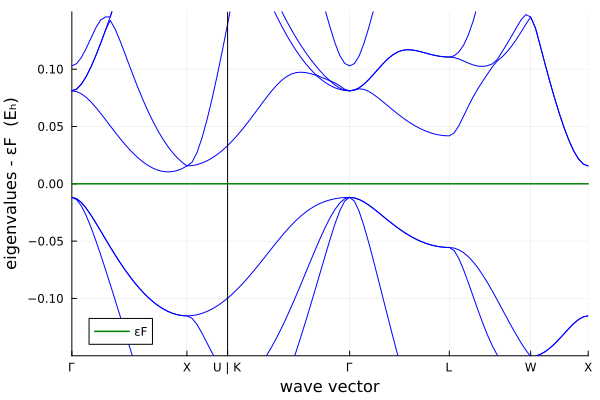

In [18]:
plot_bandstructure(bands)

In [19]:
# Band gap from band structure path
let ε = reduce(hcat, bands.eigenvalues)
    lumo = minimum(ε[ε .> scfres.εF])
    homo = maximum(ε[ε .≤ scfres.εF])
    uconvert(u"eV", (lumo - homo) * u"hartree")
end

0.6037491860520928 eV

In [20]:
# Coarse band gap
ε = reduce(hcat, scfres.eigenvalues)
lumo = minimum(ε[ε .> scfres.εF])
homo = maximum(ε[ε .≤ scfres.εF])
uconvert(u"eV", (lumo - homo) * u"hartree")

0.6431150758533033 eV

In [21]:
function bandgap(a, θ)
    basis = setup_basis(a, θ; Ecut, kgrid)
    scfres = self_consistent_field(basis; tol=1e-6)
    ε = reduce(hcat, scfres.eigenvalues)
    # A coarse approximation to the band gap, only in the SCF kgrid (no interpolation)
    lumo = minimum(ε[ε .> scfres.εF])
    homo = maximum(ε[ε .≤ scfres.εF])
    lumo - homo
end

bandgap (generic function with 1 method)

In [22]:
uconvert(u"eV", bandgap(a0, params.θ_bf) * u"hartree")

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450514976950                   -0.96    4.3    1.29s
  2   -8.452402182785       -2.72       -1.81    1.0    1.20s
  3   -8.452549580892       -3.83       -2.92    2.0    584ms
  4   -8.452557911035       -5.08       -3.41    3.0    1.16s
  5   -8.452558005284       -7.03       -4.01    1.4    849ms
  6   -8.452558011104       -8.24       -5.11    1.7    909ms
  7   -8.452558011533       -9.37       -5.50    3.0    1.28s
  8   -8.452558011538      -11.36       -6.52    1.1    761ms


0.6431139080241353 eV

In [23]:
bandgap_gradient = ForwardDiff.gradient(θ -> bandgap(a0, θ), params.θ_bf)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450484092889                   -0.96    4.3    1.15s
  2   -8.452395416136       -2.72       -1.81    1.0    705ms
  3   -8.452549646590       -3.81       -2.91    2.1    939ms
  4   -8.452557914422       -5.08       -3.42    3.0    1.15s
  5   -8.452558005440       -7.04       -4.03    1.6    876ms
  6   -8.452558011085       -8.25       -5.20    1.7    849ms
  7   -8.452558011535       -9.35       -5.55    3.1    772ms
  8   -8.452558011538      -11.50       -6.58    1.0    793ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      58.6   1.36s  Non-interacting
   1        0       1       -1.47     43.1   1.51s  
   2        0       2       -2.82     30.1   1.18s  
   3        0       3       -3.97     17.6   790ms  
 

3-element Vector{Float64}:
 0.057811890568090274
 0.0230595158035286
 0.007643284922034031

In [24]:
uconvert(u"eV", norm(params.L'bandgap_gradient) * u"hartree")

0.23797564757968928 eV

In [25]:
bandgap_gradient2 = ForwardDiff.derivative(a -> bandgap(a, params.θ_bf), a0)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450498903247                   -0.96    4.4    698ms
  2   -8.452397095764       -2.72       -1.81    1.0    990ms
  3   -8.452548722123       -3.82       -2.92    2.1    635ms
  4   -8.452557911247       -5.04       -3.37    3.0    475ms
  5   -8.452558003789       -7.03       -3.92    1.2    396ms
  6   -8.452558010837       -8.15       -4.99    1.6    361ms
  7   -8.452558011527       -9.16       -5.28    3.1    496ms
  8   -8.452558011537      -11.01       -6.18    1.0    335ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      56.9   1.07s  Non-interacting
   1        0       1       -0.86     40.4   1.66s  
   2        0       2       -2.63     34.4   963ms  
   3        0       3       -3.90     18.9   1.37s  
 

0.01770714667299579

In [26]:
bandgap_gradient_total = bandgap_gradient + bandgap_gradient2 * ∂a_∂θ

UndefVarError: UndefVarError: `∂a_∂θ` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [27]:
uconvert(u"eV", norm(params.L'bandgap_gradient_total) * u"hartree")

UndefVarError: UndefVarError: `bandgap_gradient_total` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.